# Results

In [18]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve
import matplotlib.pyplot as plt

## AUC confidence intervals

In [8]:
def bootstrap_auc(y, pred, bootstraps = 100, fold_size = 1000):
    statistics = np.zeros(bootstraps)   
    df = pd.DataFrame(columns=['y', 'pred'])
    df.loc[:, 'y'] = y
    df.loc[:, 'pred'] = pred
    # get positive examples for stratified sampling
    df_pos = df[df.y == 1]
    df_neg = df[df.y == 0]
    prevalence = len(df_pos) / len(df)
    for i in range(bootstraps):
        # stratified sampling of positive and negative examples
        pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
        neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

        y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
        pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
        score = roc_auc_score(y_sample, pred_sample)
        statistics[i] = score
    return statistics

def print_confidence_intervals(statistics):
    df = pd.DataFrame(columns=["Mean AUC (CI 5%-95%)"])
    mean = statistics.mean()
    max_ = np.quantile(statistics, .95)
    min_ = np.quantile(statistics, .05)
    df.loc["Exitus"] = ["%.2f (%.2f-%.2f)" % (mean, min_, max_)]
    return df


In [10]:
path_tabular = '/home/iexpress/TCGA/data/'

In [13]:
tab_dat = pd.read_csv(os.path.join(path_tabular, 'clean_data.csv'), sep = ';')
selected_columns = ["|" not in i for i in tab_dat.columns]
tab_dat = tab_dat[tab_dat.columns[selected_columns]]
tab_X_train = tab_dat[tab_dat.dataset.values == 'train']
tab_X_val = tab_dat[tab_dat.dataset.values == 'val']
tab_X_test = tab_dat[tab_dat.dataset.values == 'test']
y_train = tab_X_train['target']
y_val = tab_X_val['target']
y_test = tab_X_test['target']
del tab_X_train['dataset']
del tab_X_val['dataset']
del tab_X_test['dataset']
del tab_X_train['target']
del tab_X_val['target']
del tab_X_test['target']
del tab_X_train['index']
del tab_X_val['index']
del tab_X_test['index']

In [6]:
pred_train = np.loadtxt(os.path.join('/home/iexpress/TCGA/saved_models/predictions', 'predictions_train_mixed.csv'), delimiter=";")
pred_val = np.loadtxt(os.path.join('/home/iexpress/TCGA/saved_models/predictions', 'predictions_val_mixed.csv'), delimiter=";")
pred_test = np.loadtxt(os.path.join('/home/iexpress/TCGA/saved_models/predictions', 'predictions_test_mixed.csv'), delimiter=";")

In [16]:
AUC_CI_train = bootstrap_auc(y_train, pred_train, bootstraps = 100, fold_size = 100,)
AUC_CI_val = bootstrap_auc(y_val, pred_val, bootstraps = 100, fold_size = 100)
AUC_CI_test = bootstrap_auc(y_test, pred_test, bootstraps = 100, fold_size = 100,)
AUC_CI = print_confidence_intervals(AUC_CI_train,)
AUC_CI = AUC_CI.append(print_confidence_intervals(AUC_CI_val), ignore_index=True)
AUC_CI = AUC_CI.append(print_confidence_intervals(AUC_CI_test), ignore_index=True)
AUC_CI.index = ['Train', 'Val', 'Test'];
AUC_CI

,Mean AUC (CI 5%-95%)
Train,0.94 (0.92-0.95)
Val,0.87 (0.85-0.88)
Test,0.84 (0.82-0.86)


## Plot AUC

In [27]:
pred_standard = np.loadtxt(os.path.join('/home/iexpress/TCGA/saved_models/predictions', 'predictions_standard.csv'), delimiter=";")
pred_gene = np.loadtxt(os.path.join('/home/iexpress/TCGA/saved_models/predictions', 'predictions_gene.csv'), delimiter=";")
pred_all = np.loadtxt(os.path.join('/home/iexpress/TCGA/saved_models/predictions', 'predictions_all.csv'), delimiter=";")
pred_mixed = np.loadtxt(os.path.join('/home/iexpress/TCGA/saved_models/predictions', 'predictions_mixed.csv'), delimiter=";")


OSError: /home/iexpress/TCGA/saved_models/predictions/predictions_mixed.csv not found.

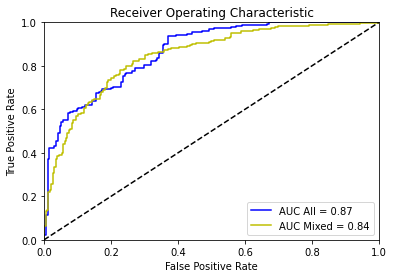

In [26]:
fpr_standard, tpr_standard, threshold_standard = roc_curve(y_test, pred_standard)
roc_auc_standard = roc_auc_score(y_true = y_test, y_score = pred_standard)
fpr_gene, tpr_gene, threshold_gene = roc_curve(y_test, pred_gene)
roc_auc_gene = roc_auc_score(y_true = y_test, y_score = pred_gene)
fpr_all, tpr_all, threshold_all = roc_curve(y_val, pred_all)
roc_auc_all = roc_auc_score(y_true = y_val, y_score = pred_all)
fpr_mixed, tpr_mixed, threshold_mixed = roc_curve(y_val, pred_mixed)
roc_auc_mixed = roc_auc_score(y_true = y_val, y_score = pred_mixed)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_standard, tpr_standard, 'y', label = 'AUC Standard = %0.2f' % roc_auc_standard)
plt.plot(fpr_gene, tpr_gene, 'r', label = 'AUC Gene = %0.2f' % roc_auc_gene)
plt.plot(fpr_all, tpr_all, 'g', label = 'AUC All = %0.2f' % roc_auc_all)
plt.plot(fpr_mixed, tpr_mixed, 'b', label = 'AUC Mixed = %0.2f' % roc_auc_mixed)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()